# Entropy computation of Wang model

Please find the required packages dealing with compartmental systems at https://github.com/MPIBGC-TEE.

In [1]:
# general imports
import string
from sympy import solve, Matrix, Number, simplify
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

# import Wang model from bgc_md2 model database
from bgc_md2.models.Wang2014BG2p.source import mvs

# LAPM handles compartmental systems in equilibrium
from LAPM.linear_autonomous_pool_model import LinearAutonomousPoolModel as LAPM

## Load the general model structure

In [2]:
# create a smooth reservoir model from the database
srm = mvs.get_SmoothReservoirModel()

{SmoothReservoirModel,InFluxesBySymbol,OutFluxesBySymbol,InternalFluxesBySymbol}
{InternalFluxesBySymbol,InputTuple,OutFluxesBySymbol,SmoothReservoirModel,InFluxesBySymbol,CompartmentalMatrix,OutputTuple}
{InternalFluxesBySymbol,InputTuple,OutFluxesBySymbol,SmoothReservoirModel,InFluxesBySymbol,CompartmentalMatrix,OutputTuple}


In [3]:
B = srm.compartmental_matrix
B

Matrix([
[       -C_b*V_s/(C_s + K_s),  mu_b],
[C_b*V_s*epsilon/(C_s + K_s), -mu_b]])

In [4]:
u = srm.external_inputs
u

Matrix([
[F_NPP],
[    0]])

## Plot the model

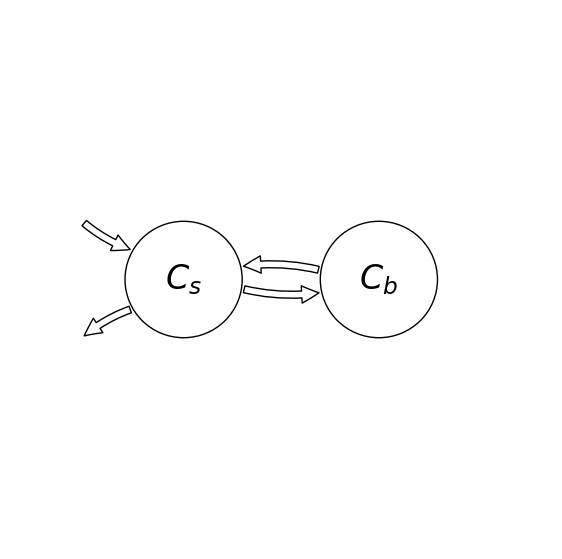

In [5]:
fig, ax = plt.subplots(figsize=(7,7))
srm.plot_pools_and_fluxes(ax, black_and_white=True, legend=False)

## Provide pool names and parameter values

In [6]:
pool_names = ["substrate carbon", "microbial biomass carbon"]

In [7]:
par_dict = {
    "mu_b": 4.38,
    "F_NPP": 345,
    "V_s": 59.13,
    "K_s": 53954,
#    "epsilon": 0.39, # original publication value
}

In [8]:
B.subs(par_dict)

Matrix([
[       -59.13*C_b/(C_s + 53954),  4.38],
[59.13*C_b*epsilon/(C_s + 53954), -4.38]])

In [9]:
u.subs(par_dict)

Matrix([
[345],
[  0]])

## Compute steady state of the original model with ``epsilon=0.39``

In [10]:
# add epsilon value to parameters
par_dict_extended = par_dict.copy()
par_dict_extended["epsilon"] = 0.39  

# compute steady state by equation right hande side to zero
ss_dict = solve(srm.F, srm.state_vector, dict=True)[0]
xss = Matrix(2, 1, [ss_dict[srm.state_vector[0]], ss_dict[srm.state_vector[1]]])

# add steady state to parameters (model is nonlinear)
par_dict_extended["C_s"] = xss[0]
par_dict_extended["C_b"] = xss[1]

# eqilibrium model
m_eq = LAPM(u.subs(par_dict_extended), B.subs(par_dict_extended))
m_eq.xss

Matrix([
[12650.4103165299],
[ 50.359308331462]])

## Prepare and the computations in dependence of the CUE epsilon

In [11]:
# carbon use efficiencies (CUEs)
epsilons = np.arange(0.1, 1.00, 0.02)

In [12]:
def create_Wang_model(epsilon):
    """Create model in equilibrium dependent on ``epsilon``."""
    par_dict_extended = par_dict.copy()
    par_dict_extended["epsilon"] = epsilon
    
    ss_dict = solve(srm.F, srm.state_vector, dict=True)[0]
    xss = Matrix(2, 1, [ss_dict[srm.state_vector[0]], ss_dict[srm.state_vector[1]]])    
    par_dict_extended["C_s"] = xss[0]
    par_dict_extended["C_b"] = xss[1]
    
    return LAPM(u.subs(par_dict_extended), B.subs(par_dict_extended), force_numerical=True)

In [21]:
thetas, ETs, path_entropies, ENs, theta_Ns, xsss, Bs, exp_Hs, theta_discs, theta_conts, path_entropies_rev = [], [], [], [], [], [], [], [], [], [], []
for epsilon in epsilons:
    model = create_Wang_model(epsilon)
    model_rev = model.time_reversed_system
    
    # steady state
    xsss.append(np.array(model.xss).reshape(-1))

    # entropy rate per unit time
    theta = model.entropy_rate
    thetas.append(theta)

    # mean transit time
    ET = model.T_expected_value
    ETs.append(ET)

    # path entropy
    path_entropies.append(model.entropy_per_cycle)
    path_entropies_rev.append(model_rev.entropy_per_cycle)

    # mean number of jumps
    EN = model.absorbing_jump_chain.expected_number_of_jumps+1
    ENs.append(EN)

    #entropy rate per jump
    theta_N = model.entropy_per_jump
    theta_Ns.append(theta_N)

    # compartmental matrix
    Bs.append(model.B)
    
    # one-pool entropy
    lamda = float(1/ET)
    exp_Hs.append(1 - np.log(lamda))

    # discrete part of entropy rate per unit time
    theta_disc = model.ergodic_jump_chain.ergodic_entropy * EN / ET
    theta_discs.append(float(theta_disc))
    
    # continuous part of entropy rate per unit time
    theta_conts.append(theta - theta_disc)  

## Make the entropy plots

In [14]:
# set plot parameters

mpl.rcParams['lines.linewidth'] = 4

SMALL_SIZE = 26
MEDIUM_SIZE = 30
#BIGGER_SIZE = 30

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE, frameon=True)    # legend fontsize
#plt.rc('legend', fontsize=SMALL_SIZE, frameon=False)    # legend fontsize
#plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

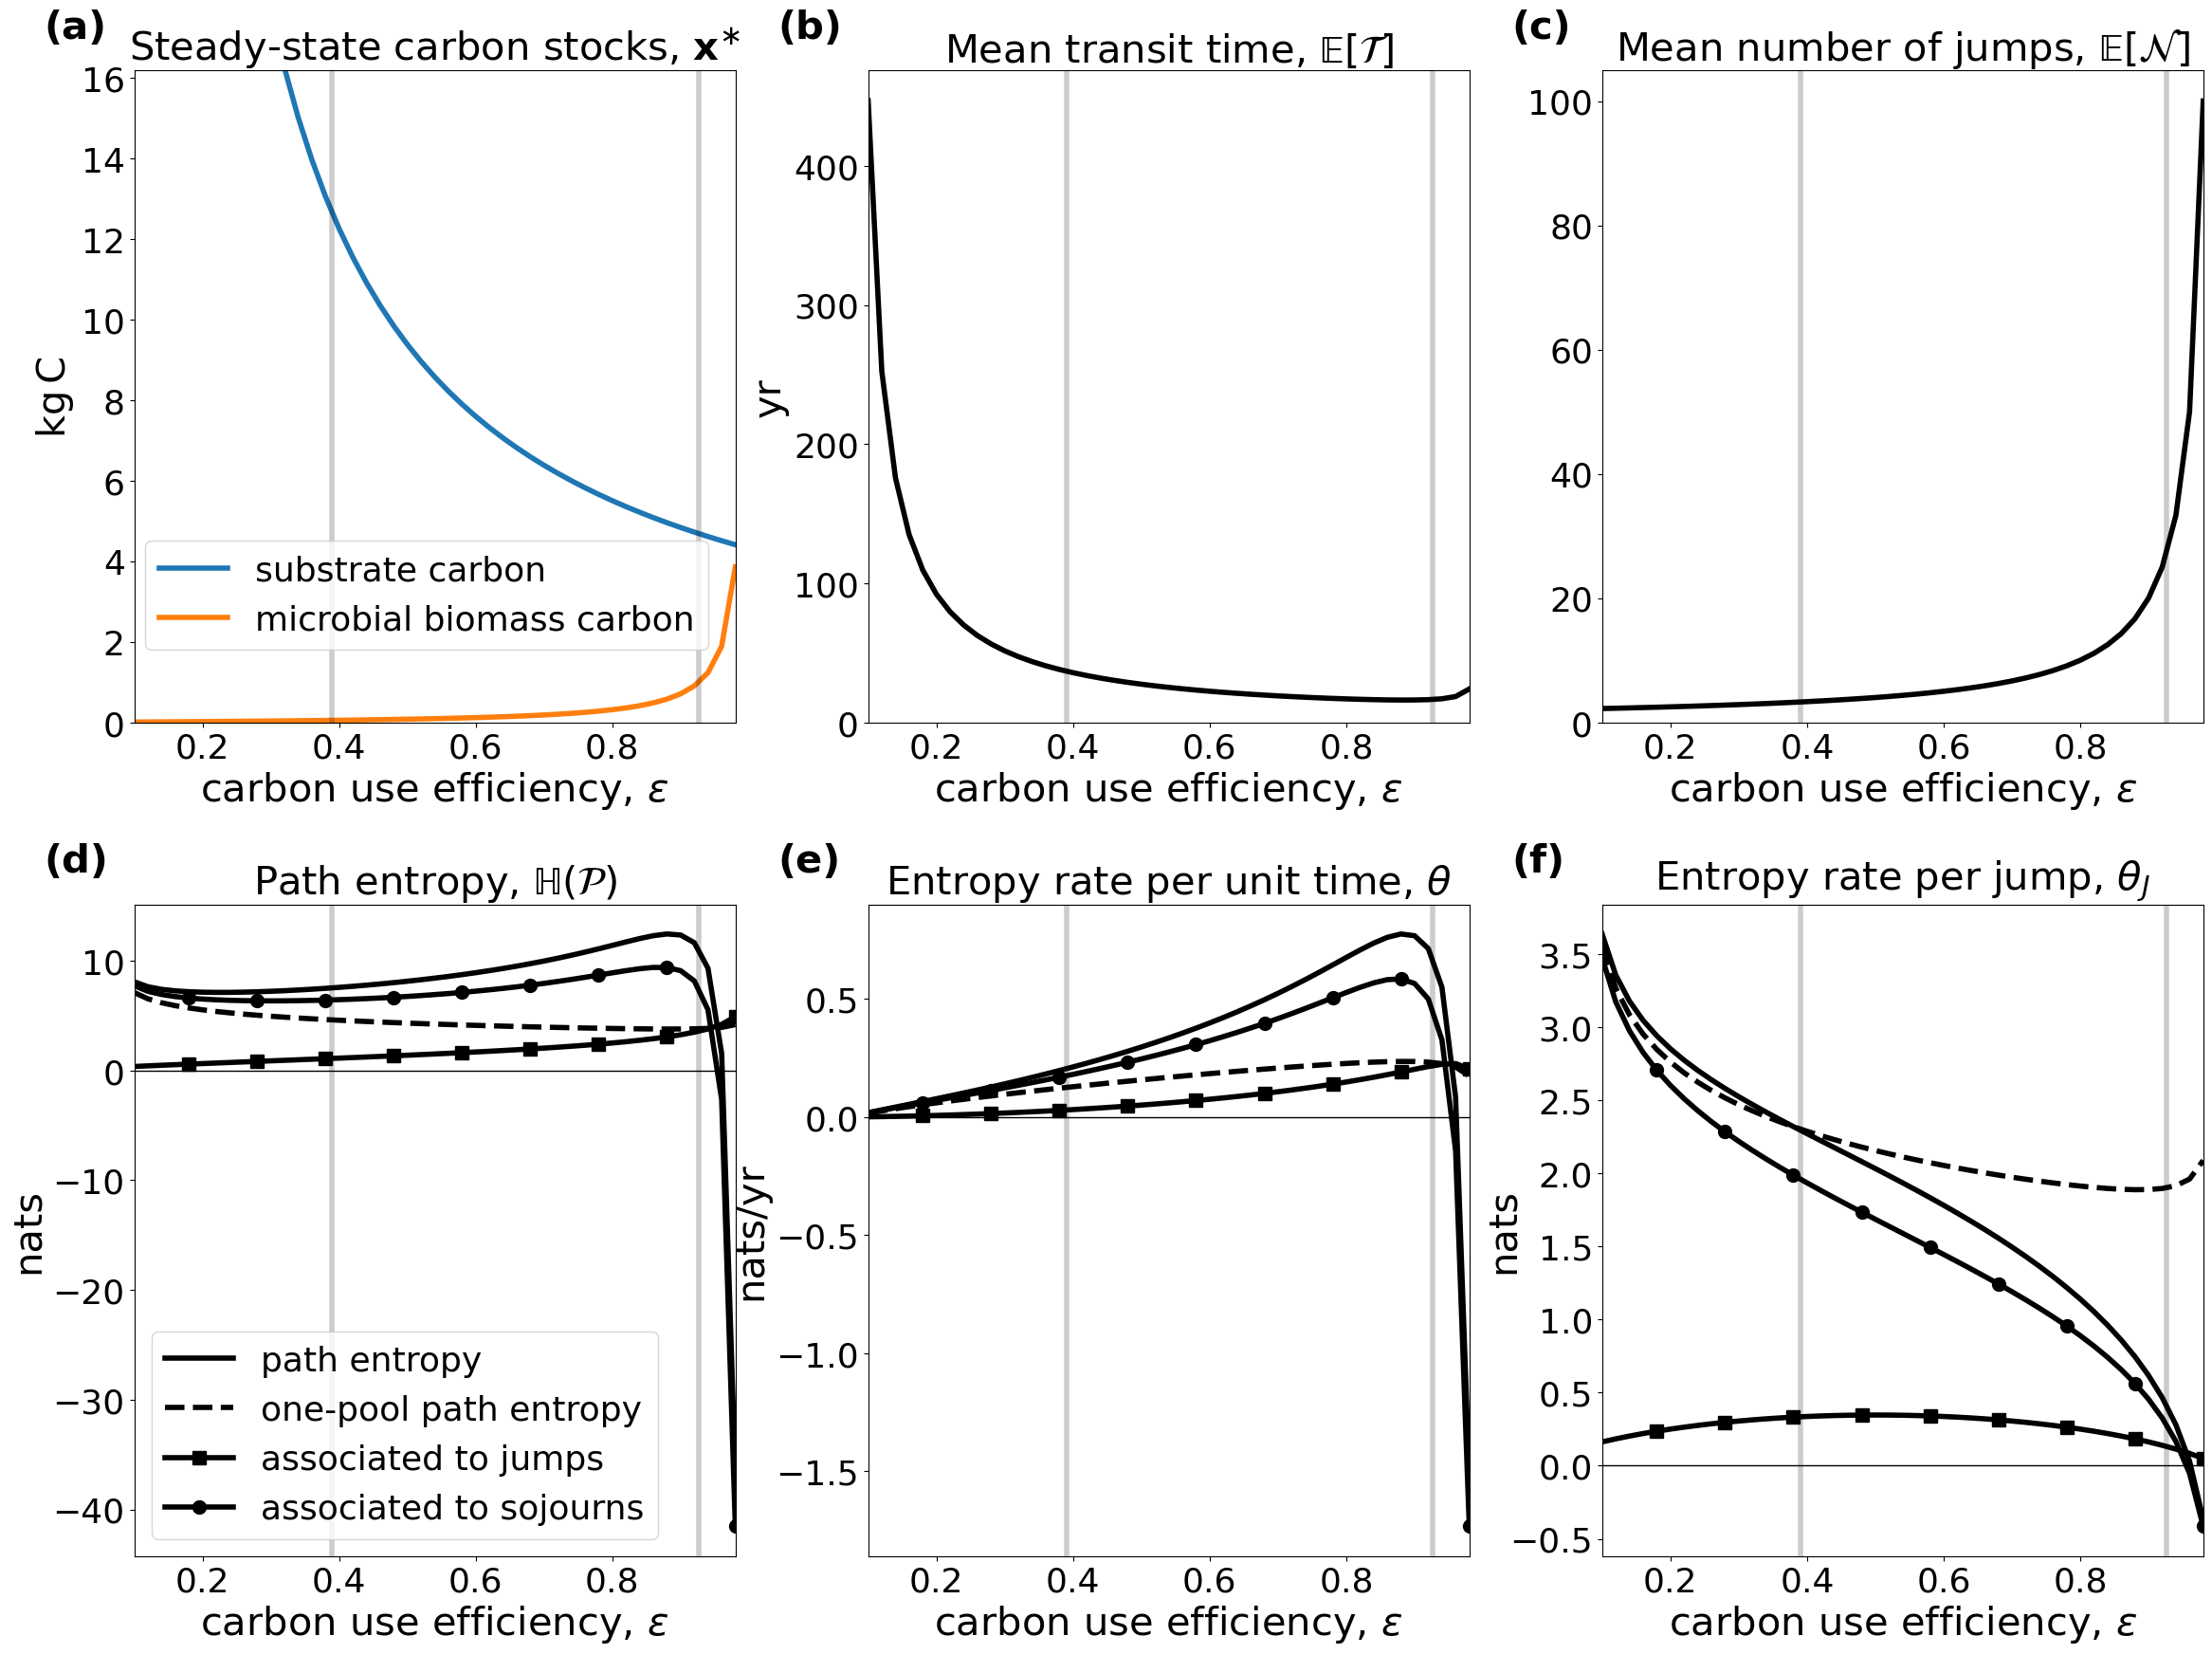

In [15]:
fig, axes = plt.subplots(figsize=(8*3, 6*3), nrows=2, ncols=3)
axes_list = axes.flatten()
#panel_names = iter(string.ascii_uppercase[:len(axes_list)])
panel_names = iter(string.ascii_lowercase[:len(axes_list)])
[ax.set_xlabel(r"carbon use efficiency, $\varepsilon$") for ax in axes_list]

axes = iter(axes_list)

ax = next(axes)
ax.set_title(r"Steady-state carbon stocks, $\mathbf{x}^{\ast}$")
lines = ax.plot(epsilons, np.array(xsss)*1e-03)
#ax.legend(lines, pool_names, loc=3)
ax.set_ylim([0, ax.get_ylim()[1]/10])
ax.set_ylabel("kg$\,$C")
ax.legend(
    lines,
    pool_names,
    bbox_to_anchor=(-0.01, .085, -0.01, 0.085),
    loc='lower left',
#    ncols=2, mode="expand", borderaxespad=0.
)


ax = next(axes)
ax.set_title(r"Mean transit time, $\mathrm{\mathbb{E}}\left[\mathcal{T}\right]$")
ax.plot(epsilons, ETs, c="black")
ax.set_ylim([np.maximum(0, ax.get_ylim()[0]), ax.get_ylim()[1]])
ax.set_ylabel("yr")


ax = next(axes)
ax.set_title(r"Mean number of jumps, $\mathrm{\mathbb{E}}\left[\mathcal{N}\right]$")
ax.plot(epsilons, ENs, c="black")
ax.set_ylim([np.maximum(0, ax.get_ylim()[0]), ax.get_ylim()[1]])


ax = next(axes)
ax.set_title(r"Path entropy, $\mathrm{\mathbb{H}}(\mathcal{P})$")
ax.plot(epsilons, path_entropies, label="path entropy", c="black")
ax.plot(epsilons, exp_Hs, label="one-pool path entropy", c="black", ls="--")

ax.plot(epsilons, np.array(theta_discs)*np.array(ETs), label="associated to jumps", c="black", marker="s", markevery=np.arange(len(epsilons))[-1::-5], markersize=10)
ax.plot(epsilons, np.array(theta_conts)*np.array(ETs), label="associated to sojourns", c="black", marker="o", markevery=np.arange(len(epsilons))[-1::-5], markersize=10)
ax.axhline(0, c="black", lw=1)

ax.legend()
ax.set_ylabel("nats")


ax = next(axes)
ax.set_title(r"Entropy rate per unit time, $\theta$")
ax.plot(epsilons, thetas, label="entropy rate", c="black")
ax.plot(epsilons, np.array(exp_Hs)/np.array(ETs), label="one-pool entropy rate", c="black", ls="--")

ax.plot(epsilons, theta_discs, label="associated to jumps", c="black", marker="s", markevery=np.arange(len(epsilons))[-1::-5], markersize=10)
ax.plot(epsilons, theta_conts, label="associated to sojourns", c="black", marker="o", markevery=np.arange(len(epsilons))[-1::-5], markersize=10)
ax.axhline(0, c="black", lw=1)


#ax.legend()
ax.set_ylabel("nats/yr")


ax = next(axes)
ax.set_title(r"Entropy rate per jump, $\theta_J$")
ax.plot(epsilons, theta_Ns, c="black", label="entropy rate")
ax.plot(epsilons, np.array(exp_Hs)/2, label="one-pool entropy rate", c="black", ls="--")

ax.plot(epsilons, np.array(theta_discs)*np.array(ETs)/np.array(ENs), label="associated to jumps", c="black", marker="s", markevery=np.arange(len(epsilons))[-1::-5], markersize=10)
ax.plot(epsilons, np.array(theta_conts)*np.array(ETs)/np.array(ENs), label="associated to sojourns", c="black", marker="o", markevery=np.arange(len(epsilons))[-1::-5], markersize=10)
ax.axhline(0, c="black", lw=1)
ax.set_ylabel("nats", labelpad=-10)
#ax.legend()

for ax, panel_name in zip(axes_list, panel_names):
    ax.set_xlim([min(epsilons), max(epsilons)])
    ax.axvline(0.39, color="black", alpha=0.2)
    ax.axvline(0.926, color="black", alpha=0.2)
    ax.text(-0.15, 1.05, f"({panel_name})", transform=ax.transAxes, size=MEDIUM_SIZE, weight='bold')
    
fig.tight_layout(w_pad=-1.2, h_pad=1.0)

## Turnover rates of the first pool with increasing CUE

In [16]:
[-B[0,0] for B in Bs]

[0.00248668618947004,
 0.00450510030429963,
 0.00661739414540035,
 0.00883027340750587,
 0.0111510979994702,
 0.0135879638210327,
 0.0161497971206241,
 0.0188464637517730,
 0.0216888961467677,
 0.0246892414525954,
 0.0278610350616133,
 0.0312194047652794,
 0.0347813120267433,
 0.0385658384920488,
 0.0425945279551159,
 0.0468917967157208,
 0.0514854288391261,
 0.0564071775427746,
 0.0616935002244711,
 0.0673864631124520,
 0.0735348630314713,
 0.0801956296104089,
 0.0874355932831672,
 0.0953337354716308,
 0.103984081678043,
 0.113499462505097,
 0.124016462366577,
 0.135702017768222,
 0.148762344393590,
 0.163455211847129,
 0.180107128294473,
 0.199137889948581,
 0.221096461087935,
 0.246714794083849,
 0.276991005806293,
 0.313322459873226,
 0.357727570399477,
 0.413233958557290,
 0.484599314760193,
 0.579753123030731,
 0.712968454609483,
 0.912791451977613,
 1.24582978092449,
 1.91190643881826,
 3.91013641249956]

## Identify CUE such that `B[0,0] = 1` (max. entrop rate per unit time in C_S)

In [17]:
def g(eps):
    """Auxiliary function for root solve."""
    par_dict_extended_epsilon = par_dict_extended.copy()
    par_dict_extended_epsilon['epsilon'] = float(eps)

    # difference of B[0,0] and -1
    return -float(B[0,0].subs(par_dict_extended_epsilon)) - 1

In [18]:
from scipy.optimize import root

In [19]:
# solve with arbitrary initial value
root(g, 0.5)

 message: The solution converged.
 success: True
  status: 1
     fun: 9.992007221626409e-15
       x: [ 9.264e-01]
    nfev: 23
    fjac: [[-1.000e+00]]
       r: [-1.476e+01]
     qtf: [ 2.271e-09]

In [28]:
# Time-reversed path entropy equals path entropy

In [29]:
diff = np.abs(np.array(path_entropies) - np.array(path_entropies_rev))
diff > 1e-1


array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False])